In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

In [2]:
prices_train = pd.read_excel("train_data.xlsx")
print(prices_train.head())
print(prices_train.tail())

        Date     BYDDF        TSLA
0 2023-01-03  8.265224  108.099998
1 2023-01-04  8.678808  113.639999
2 2023-01-05  8.630341  110.339996
3 2023-01-06  8.497865  113.059998
4 2023-01-09  8.423548  119.769997
          Date      BYDDF        TSLA
517 2025-01-27  11.611623  397.149994
518 2025-01-28  11.565466  398.089996
519 2025-01-29  11.621513  389.100006
520 2025-01-30  11.848998  400.279999
521 2025-01-31  11.545685  404.600006


In [3]:
prices_train = prices_train.set_index("Date")

In [4]:
prices_train = prices_train.astype("float64")

In [5]:
log_prices_train = np.log(prices_train)

In [6]:
def adf_test(series, name="", maxlag=None):
    """
    Run Augmented Dickey-Fuller test, print results.
    H0: series has a unit root (non-stationary).
    """
    result = adfuller(series, maxlag=maxlag, autolag="AIC")
    test_stat = result[0]
    p_value = result[1]
    used_lag = result[2]
    n_obs = result[3]
    crit_vals = result[4]

    print(f"ADF Test on {name}")
    print(f"  Test statistic: {test_stat:.4f}")
    print(f"  p-value:       {p_value:.4f}")
    print(f"  Used lags:     {used_lag}")
    print(f"  N obs:         {n_obs}")
    print("  Critical values:")
    for key,value in crit_vals.items():
        print(f"     {key}: {value:.4f}")
    print("-"*50)

In [7]:
for col in log_prices_train.columns:
    adf_test(log_prices_train[col], name=f"log {col}")

ADF Test on log BYDDF
  Test statistic: -2.1759
  p-value:       0.2151
  Used lags:     0
  N obs:         521
  Critical values:
     1%: -3.4430
     5%: -2.8671
     10%: -2.5697
--------------------------------------------------
ADF Test on log TSLA
  Test statistic: -1.9561
  p-value:       0.3061
  Used lags:     0
  N obs:         521
  Critical values:
     1%: -3.4430
     5%: -2.8671
     10%: -2.5697
--------------------------------------------------


ADF ON FIRST-DIFFERENCES

In [8]:
log_diff_train = log_prices_train.diff().dropna()

for col in log_diff_train.columns:
    adf_test(log_diff_train[col], name=f"delta log {col}")

ADF Test on delta log BYDDF
  Test statistic: -22.8257
  p-value:       0.0000
  Used lags:     0
  N obs:         520
  Critical values:
     1%: -3.4430
     5%: -2.8671
     10%: -2.5697
--------------------------------------------------
ADF Test on delta log TSLA
  Test statistic: -22.6473
  p-value:       0.0000
  Used lags:     0
  N obs:         520
  Critical values:
     1%: -3.4430
     5%: -2.8671
     10%: -2.5697
--------------------------------------------------


FITTING VAR AND SELECTING LAG

In [9]:
log_prices_train.head()

,BYDDF,TSLA
Date,,
2023-01-03,2.112057,4.683057
2023-01-04,2.160884,4.733036
2023-01-05,2.155284,4.703566
2023-01-06,2.139815,4.727919
2023-01-09,2.131031,4.785573


In [10]:
var_model = VAR(log_prices_train)

lag_order_results = var_model.select_order(maxlags=10)

print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -7.501      -7.484   0.0005527      -7.494
1      -14.27*     -14.22*  6.323e-07*     -14.25*
2       -14.26      -14.18   6.385e-07      -14.23
3       -14.25      -14.14   6.456e-07      -14.21
4       -14.25      -14.10   6.481e-07      -14.19
5       -14.25      -14.07   6.470e-07      -14.18
6       -14.24      -14.02   6.541e-07      -14.16
7       -14.23      -13.98   6.605e-07      -14.13
8       -14.22      -13.94   6.642e-07      -14.11
9       -14.22      -13.90   6.685e-07      -14.10
10      -14.21      -13.86   6.744e-07      -14.07
--------------------------------------------------


/Users/arshaq/Desktop/BO Cointegration/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
selected_lag = lag_order_results.selected_orders['bic']

In [12]:
k_ar_diff = max(selected_lag - 1, 1)
print("Using k_ar_diff for Johansen:", k_ar_diff)

Using k_ar_diff for Johansen: 1


JOHANSEN TEST

In [13]:
data_joh = log_prices_train.values
data_joh[0:5]

array([[2.11205677, 4.68305671],
       [2.16088422, 4.73303555],
       [2.15528397, 4.70356647],
       [2.13981492, 4.72791863],
       [2.13103109, 4.78557321]])

In [14]:
det_order = 0

jres = coint_johansen(data_joh, det_order, k_ar_diff)

In [15]:
print("Trace statistics (lr1):", jres.lr1)
print("Trace critical values cvt (90%, 95%, 99%):")
print(jres.cvt)

print("\nMax eigenvalue statistics (lr2):", jres.lr2)
print("Max eigen critical values cvm (90%, 95%, 99%):")
print(jres.cvm)

Trace statistics (lr1): [15.49450154  3.1491724 ]
Trace critical values cvt (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Max eigenvalue statistics (lr2): [12.34532914  3.1491724 ]
Max eigen critical values cvm (90%, 95%, 99%):
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [16]:
beta = jres.evec[:, 0]  
print("Raw beta:", beta)

Raw beta: [10.35474873 -4.02849884]


In [17]:
beta_norm = beta / np.sum(np.abs(beta))
if beta_norm[0] < 0:
    beta_norm = -beta_norm

print("Normalised beta:", beta_norm)

Normalised beta: [ 0.7199173 -0.2800827]


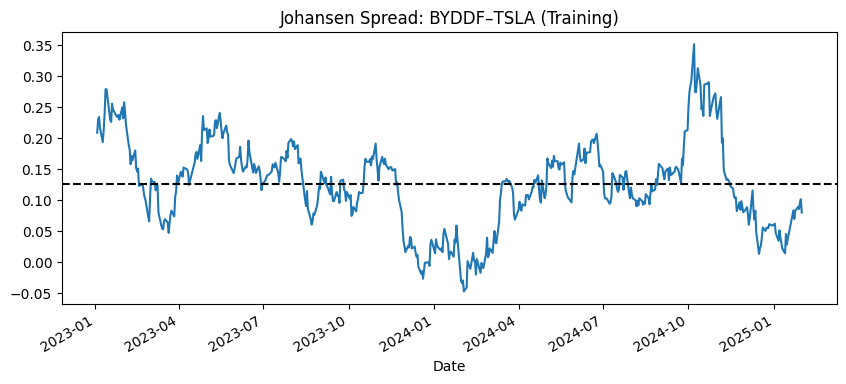

In [19]:
spread_train = log_prices_train.values @ beta_norm 
spread_train = pd.Series(spread_train, index=log_prices_train.index, name="BYDDF_TSLA_spread")

spread_train.plot(figsize=(10, 4), title="Johansen Spread: BYDDF–TSLA (Training)")
plt.axhline(spread_train.mean(), color="black", linestyle="--")
plt.show()

In [20]:
adf_test(spread_train, name="Johanses Spread BYDDF-TESLA")

ADF Test on Johanses Spread BYDDF-TESLA
  Test statistic: -2.9474
  p-value:       0.0401
  Used lags:     0
  N obs:         521
  Critical values:
     1%: -3.4430
     5%: -2.8671
     10%: -2.5697
--------------------------------------------------
